In [1]:
import numpy as np
from itertools import combinations, product
from scipy.optimize import linprog, minimize
import pandas as pd
import scipy.spatial.distance as distance
import matplotlib.pyplot as plt
from tqdm import tqdm
from joblib import Parallel, delayed

In [2]:
T = 5
scenarios = pd.DataFrame(index=range(2**T), columns=range(T+1), dtype=float)

steps = [i for i in product([-1,1], repeat=T)]
for t in range(2**T):
    scenarios.iloc[t, :] = np.cumsum([0] + list(steps[t]))

In [3]:
x = scenarios.values
cdn = 3
w = None
p = 1
dist = 'energy'

parallel=True

In [4]:
class ReduceExact():
    """
    Reduction class to reduce scenarios by their energy score.
    Applies the exact method, which is exhaustive and evaluates the distance for all possible scenario combinations.
    """

    def __init__(self, x, cdn, w=None, p=1, dist='energy', parallel=True, COMB=None, distx=None):
        """
        :param x: array of scenarios
        :param cdn: number of reduced scenarios
        :param w: weights for the energy score (probabilities)
        :param p: p-norm for the energy score
        :param parallel: whether to use parallel processing (n_jobs=-1)
        """
        self.x = x
        self.cdn = cdn
        self.w = w
        self.p = p
        self.dist = dist
        self.parallel = parallel
        self.distx = distx

        # Determine number of scenarios to select
        if self.cdn is None:
            self.cdn = int(np.floor(np.log(self.x.shape[0])))

        # Normalize weights
        if self.w is None:
            self.w = np.ones(self.x.shape[0])/self.x.shape[0]
        else:
            self.w = self.w/np.sum(self.w)

        if COMB is None:
            # Compute combinations of scenarios to select
            self.COMB = np.array(list(combinations(range(x.shape[0]), self.cdn))).T
        else:
            # Option to provide your own combination list to try so we can easily apply it to the forward algorithm too
            self.COMB = COMB

        if distx is None:
            if self.dist == 'energy':
                # Compute distance matrix
                self.distx = np.power(np.array(np.asmatrix(distance.cdist(self.x, self.x, metric='euclidean'))), self.p)
            elif self.dist == 'wasserstein':
                # For wasserstein keep the original scenario set
                # self.distx = self.x
                self.distx = np.power(np.array(np.asmatrix(distance.cdist(self.x, self.x, metric='euclidean'))), self.p)
        else:
            # Option to provide your own distance matrix to try so we can efficiently apply it to the forward algorithm too
            self.distx = distx


    def reduce_exact(self):
        # Compute distance matrix
        self.optz = np.zeros(self.COMB.shape[1]) # optimal value of the objective function
        self.optc = np.zeros((self.COMB.shape[1], self.cdn)) # optimal weights of the scenarios
        
        if not self.parallel:
            for i_z in tqdm(range(self.optz.shape[0])):
                index_array = self.COMB[:,i_z]
                out = self.get_val(index_array)
                self.optz[i_z] = out[0]
                self.optc[i_z,:] = out[1]
        else:
            index_arrays = [self.COMB[:,i_z] for i_z in range(self.optz.shape[0])]
            out = Parallel(n_jobs=-1, verbose=1)(delayed(self.get_val)(i_arr) for i_arr in index_arrays)
            for i_z in range(self.optz.shape[0]):
                self.optz[i_z] = out[i_z][0]
                self.optc[i_z,:] = out[i_z][1]

        # Return the optimal set of scenarios and their weights
        self.idx = np.argmin(self.optz)
        self.res = np.column_stack((self.COMB[:,self.idx], self.optc[self.idx,:]))
        self.res = self.res[np.argsort(self.res[:, 0]), :]
        self.res[:, 1] = self.res[:, 1]/np.sum(np.abs(self.res[:, 1]))
        self.make_df()

    def get_val(self, i_arr):
        if self.dist == 'energy':
            return self.get_energy_score_weights_(i_arr)
        elif self.dist == 'wasserstein':
            return self.get_wasserstein_distance_weights_(i_arr)

    def get_energy_score_weights_(self, i_arr):
        # Function to minimize for each combination of scenarios to select (i_z)
        b = 2*np.dot(self.distx, self.w)
        A_z = self.distx[i_arr,:][:,i_arr]
        b_z = b[i_arr]
        
        bounds = [(0, 1) for i in range(self.cdn)]
        res = minimize(fun=lambda x: np.dot(x, b_z) - np.dot(x, np.dot(A_z, x)),
                        x0=np.ones(self.cdn)/self.cdn,
                        method='SLSQP',
                        bounds=bounds,
                        constraints={'type': 'eq', 'fun': lambda x: np.sum(x)-1})
        x_z = res.x
        obj_val = np.power(res.fun, 1/self.p)
        return [obj_val, x_z]
    
    def get_wasserstein_distance_weights_(self, index_array):
        xn = self.distx.shape[0]
        J = np.delete(np.arange(xn), index_array)
        d = self.distx[index_array[:,None],J]
        ji = index_array[np.apply_along_axis(np.argmin, 0, d)]
        wr = self.w.copy()
        for i, j in enumerate(ji):
            wr[j] += self.w[J[i]]
        www = self.w[J]
        return [np.power(np.dot(www, np.apply_along_axis(np.min, 0, d)), 1/self.p), wr[index_array]]

    def make_df(self):
        # Make a dataframe with the optimal set of scenarios and their weights
        self.clusters = pd.DataFrame(index=range(self.res.shape[0]), columns=range(self.x.shape[1]))
        self.cluster_idx = [int(self.res[i, 0]) for i in range(self.res.shape[0])]
        self.clusters.iloc[:,:] = self.x[self.cluster_idx,:]
        self.clusters['weight'] = self.res[:, 1]

In [8]:
clusterer = ReduceExact(x=x, cdn=cdn, w=w, p=p, parallel=True, dist='wasserstein')

In [9]:
clusterer.reduce_exact()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 4550 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 4960 out of 4960 | elapsed:    1.4s finished


In [10]:
clusterer.clusters

,0,1,2,3,4,5,weight
0,0.0,-1.0,-2.0,-3.0,-2.0,-3.0,0.25000
1,0.0,-1.0,0.0,-1.0,0.0,-1.0,0.34375
2,0.0,1.0,2.0,1.0,2.0,1.0,0.40625


In [130]:
# idx = np.where(clusterer.optz == np.min(clusterer.optz))[0]
# print(idx)
# for i in idx:
#     print(i)
#     scenarios = clusterer.x[clusterer.COMB[:,i]]
#     weights = clusterer.optc[i,:]
#     print(scenarios)
#     print(weights)
#     print()

In [11]:
class ReduceForward():
    """
    Reduction class to reduce scenarios by their energy score.
    Applies the forward method, which is greedy and selects the scenario with the lowest energy score.
    """

    def __init__(self, x, cdn, w=None, dist='energy', p=1, parallel=True):
        """
        :param x: array of scenarios
        :param cdn: number of reduced scenarios
        :param parallel: whether to use parallel processing (n_jobs=-1)
        """
        self.x = x
        self.cdn = cdn
        self.w = w
        self.dist = dist
        self.p = p
        self.parallel = parallel
        self.tracker = {}
        self.weights = None
        self.reduced_df = None

        # Determine number of scenarios to select
        if self.cdn is None:
            self.cdn = int(np.floor(np.log(self.x.shape[0])))

        # Normalize weights
        if self.w is None:
            self.w = np.ones(self.x.shape[0])/self.x.shape[0]
        else:
            self.w = self.w/np.sum(self.w)

        # Compute distance matrix
        self.distx = np.array(np.asmatrix(distance.cdist(self.x, self.x, metric='euclidean')))
        self.distx = np.power(self.distx, p)

    def reduce_forward(self):
        self.reduced_set = set()
        self.candidate_set =set({i for i in range(self.x.shape[0])})

        # Select the first scenario
        while len(self.reduced_set) < self.cdn:
            scenarios = self.select_scenario(return_scenarios=True)
            new = [s for s in scenarios if s not in self.reduced_set][0]
            self.reduced_set.add(new)
            self.candidate_set.remove(new)

        # Return the optimal set of scenarios and their weights
        self.res = np.column_stack((np.array(list(self.reduced_set)), self.weights))
        self.res = self.res[np.argsort(self.res[:, 0]), :]
        self.res[:, 1] = self.res[:, 1]/np.sum(np.abs(self.res[:, 1]))

        self.make_df()

    def select_scenario(self, return_scenarios=True):
        # Make a new array with the combinations of scenarios to select
        # Array rows consists of scenarios, columns consist of combinations
        # The reduced set fills the first rows, the new candidates fill the last row

        comb_array = np.zeros((len(self.reduced_set) + 1, len(self.candidate_set)))
        
        for i in range(len(self.reduced_set)):
            comb_array[i, :] = np.ones(comb_array.shape[1]) * list(self.reduced_set)[i]
        comb_array[-1, :] = np.array(list(self.candidate_set))
        comb_array = comb_array.astype(int)

        # Get the exact solution for each combination
        clusterer = ReduceExact(x=self.x,
                                cdn=comb_array.shape[0], 
                                w=self.w, 
                                p=self.p, 
                                parallel=self.parallel, 
                                COMB=comb_array, 
                                distx=self.distx,
                                dist=self.dist)

        clusterer.reduce_exact()
        results = clusterer.res
        score = min(clusterer.optz)
        scenario_set = results[:, 0].astype(int)
        self.weights = results[:, 1]
        step = len(self.reduced_set)
        self.tracker[step] = {'scenario_set': scenario_set, 'weights': self.weights, 'score': score}

        if return_scenarios:
            return scenario_set
        
    def make_df(self):
        # Make a dataframe with the optimal set of scenarios and their weights
        self.clusters = pd.DataFrame(index=range(self.res.shape[0]), columns=range(self.x.shape[1]))
        self.cluster_idx = [int(self.res[i, 0]) for i in range(self.res.shape[0])]
        self.clusters.iloc[:,:] = self.x[self.cluster_idx,:]
        self.clusters['weight'] = self.res[:, 1]

In [15]:
clusterer_forward = ReduceForward(x=x, cdn=cdn, w=None, dist='wasserstein', p=1, parallel=True)

In [16]:
clusterer_forward.reduce_forward()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 out of  32 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  31 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  31 out of  31 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 out of  30 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.0s finished


In [17]:
clusterer_forward.clusters

,0,1,2,3,4,5,weight
0,0.0,-1.0,-2.0,-3.0,-2.0,-3.0,0.15625
1,0.0,-1.0,0.0,-1.0,0.0,-1.0,0.43750
2,0.0,1.0,2.0,1.0,2.0,1.0,0.40625


In [142]:
s_find_ziel = { 'ES': {
                        2: [[0, 1, 0, 1, 2, 1],
                            [0, -1, 0, -1, -2, -1]],
                        3: [[0, 1, 0, 1, 0, -1],
                            [0, 1, 2, 1, 2, 3 ],
                            [0, -1, -2, -1, -2, -1]],
                        4: [[0, 1, 0, 1, 0, -1],
                            [0, -1, -2, -3, -2, -3],
                            [0, 1, 2, 3, 2, 3],
                            [0, -1, 0, -1, 0, 1]],
                        5: [[0, 1, 0, 1, 0, -1],
                            [0, -1, -2, -3, -2, -3],
                            [0, -1, 0, 1, 2, 1],
                            [0, -1, 0, -1, -2, -1],
                            [0, 1, 2, 1, 2, 3]]
    }
}

s_find_ziel = s_find_ziel['ES']
idx = []
for s in s_find_ziel[cdn]:
    idx.append(scenarios.loc[scenarios.eq(s).all(1)].index[0])

for i in range(clusterer.COMB.shape[1]):
    flag = 0
    for id in idx:
        if id in clusterer.COMB[:, i]:
            flag += 1
    if flag == len(idx):
        comb_idx_ziel = i
        break

res_ziel = clusterer.get_val(comb_idx_ziel)
weights_ziel = res_ziel[1]
clusters_ziel = pd.DataFrame(index=range(len(s_find_ziel[cdn])), columns=range(T+1), dtype=float)
for i in range(len(s_find_ziel)):
    clusters_ziel.iloc[i, :] = clusterer.x[int(s_find_ziel[cdn][i][0]),:]


AttributeError: 'numpy.ndarray' object has no attribute 'loc'

NameError: name 'comb_idx_ziel' is not defined

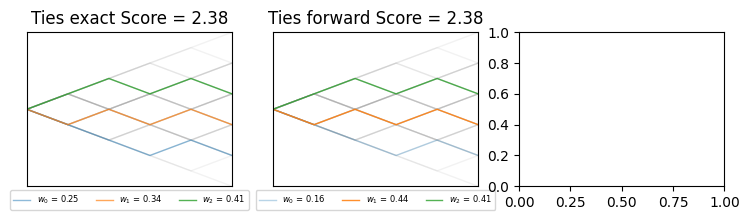

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(9, 2))

for n, ax in enumerate(axes):
    if n == 0:
        cluster_scen_idx = [int(i) for i in clusterer.res[:,0]]
        weights = clusterer.res[:,1]
    elif n==1:
        cluster_scen_idx = [int(i) for i in clusterer_forward.res[:,0]]
        weights = clusterer_forward.res[:,1]
    else:
        cluster_scen_idx = [int(i) for i in clusterer.COMB[:, comb_idx_ziel]]
        weights = weights_ziel

    for i in scenarios.index:
        if i not in cluster_scen_idx:
            ax.plot(scenarios.columns, scenarios.iloc[i,:], color='grey', alpha=0.1, lw=1)

    w_labels = [f'$w_{i}$ = {weights[i]:.2f}' for i in range(len(weights))]
    for i, scen in enumerate(cluster_scen_idx):
        ax.plot(scenarios.columns, scenarios.iloc[scen,:], alpha=min(1, weights[i]*2), lw=1, label=w_labels[i])

    title_name = {0: 'Ties exact', 1: 'Ties forward', 2: 'Ziel'}
    
    scenario_array = np.array(cluster_scen_idx)
    distweight = clusterer.get_val(scenario_array)
    dist = distweight[0]
    ax.set_title(f'{title_name[n]} Score = {round(dist, 2)}')

    ax.set_xlim(0, T)
    ax.set_ylim(-T, T)
    ax.set_xticks([])
    ax.set_yticks([])
    # Now add the legend with the weights, plot the legend horizontally at the top
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 0), ncol=3, fontsize=6)
        



In [33]:
def wasserstein_distance_md(X, Y, p=1, weights=None, tol=1e-6):
    """
    Calculates the p-Wasserstein distance between two multidimensional stochastic variables X and Y with weights.

    Args:
        X (ndarray): Array of shape (n_samples_X, n_features) representing the first stochastic variable.
        Y (ndarray): Array of shape (n_samples_Y, n_features) representing the second stochastic variable.
        p (float, optional): The p-value to use for the distance calculation. Default is 1.
        weights (tuple or list, optional): Tuple or list of two arrays containing the weights for X and Y. If None,
                                            uniform weights are used. Default is None.
        tol (float, optional): The tolerance level for the optimization problem. Default is 1e-6.

    Returns:
        float: The p-Wasserstein distance between X and Y.
        ndarray: An array of shape (n_samples_X, n_samples_Y) containing the optimal transport plan.

    Raises:
        ValueError: If X and Y have different numbers of features, or if the sum of the weights is not close to 1.
    """
    n_samples_X, n_samples_Y = X.shape[0], Y.shape[0]
    n_features_X, n_features_Y = X.shape[1], Y.shape[1]

    if n_features_X != n_features_Y:
        raise ValueError("X and Y must have the same number of features")

    if weights is None:
        weights_X = np.ones(n_samples_X) / n_samples_X
        weights_Y = np.ones(n_samples_Y) / n_samples_Y
    else:
        weights_X, weights_Y = weights

    if not np.isclose(np.sum(weights_X), 1, rtol=tol) or not np.isclose(np.sum(weights_Y), 1, rtol=tol):
        raise ValueError("Weights must sum to 1 (or close to 1)")

    
    C = np.power(distance.cdist(X, Y, metric='euclidean'), p)
    print(C.shape)
    A_eq = np.zeros((n_samples_X + n_samples_Y, n_samples_X * n_samples_Y))
    b_eq = np.zeros(n_samples_X + n_samples_Y)

    # Constraints for marginal probabilities of X and Y
    for i in range(n_samples_X):
        A_eq[i, i * n_samples_Y: (i + 1) * n_samples_Y] = 1
        b_eq[i] = weights_X[i]

    for j in range(n_samples_Y):
        A_eq[n_samples_X + j, j: n_samples_X * n_samples_Y: n_samples_Y] = 1
        b_eq[n_samples_X + j] = weights_Y[j]

    rank = np.linalg.matrix_rank(A_eq)
    if rank < n_samples_X + n_samples_Y:
        # Remove linearly dependent rows from A_eq and b_eq
        idxs = np.arange(n_samples_X + n_samples_Y)
        _, pivot_idxs = np.linalg.qr(A_eq.T)
        idxs_to_remove = np.setdiff1d(idxs, pivot_idxs[:rank])
        A_eq = np.delete(A_eq, idxs_to_remove, axis=0)
        b_eq = np.delete(b_eq, idxs_to_remove)
        
    res = linprog(C.flatten(), A_eq=A_eq, b_eq=b_eq, method="interior-point")
    T = res.x.reshape((n_samples_X, n_samples_Y))
    z = (np.sum(T * C) ** (1 / p))
    T = T.sum(axis=1)
    T = T / T.sum()
    return [z, T]

In [31]:

# Example usage:
X = np.random.rand(100, 2)   # Generate 100 samples of a 2-dimensional variable X
Y = np.random.rand(75, 2)    # Generate 50 samples of a 2-dimensional variable Y
p_x = np.ones(len(X)) / len(X)   # Set the weights for X
p_y = np.ones(len(Y)) / len(Y)   # Set the weights for Y

In [34]:
w_dist, p_x_opt = wasserstein_distance_md(x[np.array([2, 5, 7])], x, p=1)   # Calculate the Wasserstein distance with p=2 and get the optimal weights for p_x
print(w_dist)
print(p_x_opt)

(3, 32)
2.825716497331882e-10
[0.02877254 0.48561373 0.48561373]


In [224]:
from scipy.stats import wasserstein_distance
wasserstein_distance(X.flatten(), Y.flatten(), p_x, p_y)

0.048527703886303425